# [Transformers, can you rate the complexity of reading passages?](https://towardsdatascience.com/transformers-can-you-rate-the-complexity-of-reading-passages-17c76da3403?sk=0fc1d1199174a065636c186e90342c90)
### Fine-tuning RoBERTa with PyTorch to predict reading ease of text excerpts

## [Click here to learn and read about these advanced techniques and see how they can help improve results](https://medium.com/@peggy1502/fine-tuning-transformers-82e4e61e16e) 


# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import metrics
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

import torch, os, gc, random
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import transformers
from transformers import RobertaTokenizer, RobertaModel

import warnings
warnings.filterwarnings("ignore")

In [2]:
from transformers import __version__
print("Transformers version:", __version__)
print("PyTorch version:", torch.__version__)

Transformers version: 4.6.1
PyTorch version: 1.7.0


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')    

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
# https://pytorch.org/docs/stable/notes/randomness.html

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Random Seed

In [5]:
def set_random_seed(seed):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)    

# Load Data

In [6]:
# You may need to change the path to where the file resides.

df = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
print("Training dataset shape : " + str(df.shape))

Training dataset shape : (2834, 6)


In [7]:
# Preview of the dataset.

df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


From the graph below we can see that there's a record with 0 `target`, and 0 `standard error` (measure of spread of scores among multiple raters for each `excerpt`). The `excerpt` from this record is basically the baseline for all other comparisons.

We will remove this record from the dataset.

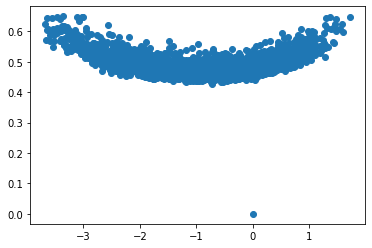

In [8]:
plt.scatter(x = df["target"], y = df["standard_error"])
plt.show()

In [9]:
# Remove record with 0 target and 0 standard_error.

df.drop(df[(df.target == 0) & (df.standard_error == 0)].index, inplace=True)
df.reset_index(drop=True, inplace=True)

print(" Training dataset shape : " + str(df.shape))

 Training dataset shape : (2833, 6)


In [10]:
# The target column values ranges from -3.676268 to 1.711390
# with mean of -0.959657.

df.describe()

,target,standard_error
count,2833.000000,2833.000000
mean,-0.959657,0.491609
std,1.033604,0.033577
min,-3.676268,0.428233
25%,-1.691501,0.468553
50%,-0.913322,0.484748
75%,-0.203079,0.506304
max,1.711390,0.649671


# Split Data into Training Set & Validation Set

In [11]:
set_random_seed(3377)
df["skfold"] = -99

df = df.sample(frac=1).reset_index(drop=True)
bins = int(np.floor(1 + np.log2(len(df))))
df.loc[:, "bins"] = pd.cut(df["target"], bins=bins, labels=False)
skf = StratifiedKFold(n_splits = 5)

for fold, (train_idx, val_idx) in enumerate(skf.split(X=df, y=df["bins"].values)):
    df.loc[val_idx, "skfold"] = fold

In [12]:
# Number of records under each fold.
df["skfold"].value_counts().sort_index()

0    567
1    567
2    567
3    566
4    566
Name: skfold, dtype: int64

In [13]:
# For each fold, the mean target is almost consistent.
# They are very close to the mean target -0.959657 for the entire dataset.

df.groupby("skfold")["target"].mean()

skfold
0   -0.957277
1   -0.964158
2   -0.960363
3   -0.968208
4   -0.948276
Name: target, dtype: float64

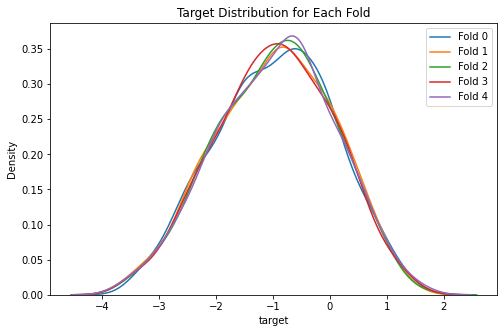

In [14]:
import seaborn as sns

plt.figure(figsize=(8,5))
for fold in range(max(df["skfold"])+1):
    sns.distplot(df[df["skfold"]==fold]["target"], 
                 hist=False,
                 kde = True,
                 label = f"Fold {fold}"
                )
    
plt.title(f"Target Distribution for Each Fold")
plt.legend(loc="best") 
plt.show()

# Dataset

In [15]:
class MyDataset(torch.utils.data.Dataset):
   
    def __init__(self, texts, targets, tokenizer, seq_len=250):        
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.seq_len = seq_len
    
    def __len__(self):
        """Returns the length of dataset."""
        return len(self.texts)
    
    def __getitem__(self, idx):
        """
        For a given item index, return a dictionary of encoded information        
        """        
        text = str(self.texts[idx]) 
        
        tokenized = self.tokenizer(
            text,            
            max_length = self.seq_len,                                
            padding = "max_length",     # Pad to the specified max_length. 
            truncation = True,          # Truncate to the specified max_length. 
            add_special_tokens = True,  # Whether to insert [CLS], [SEP], <s>, etc.   
            return_attention_mask = True            
        )     
        
        return {"ids": torch.tensor(tokenized["input_ids"], dtype=torch.long),
                "masks": torch.tensor(tokenized["attention_mask"], dtype=torch.long),
                "target": torch.tensor(self.targets[idx], dtype=torch.float)
               }

# Model

In [16]:
class MyModel(nn.Module):
            
    def __init__(self, reinit_n_layers=0):        
        super().__init__() 
        self.roberta_model = RobertaModel.from_pretrained('roberta-base')       
        self.regressor = nn.Linear(768, 1)  
        self.reinit_n_layers = reinit_n_layers
        if reinit_n_layers > 0: self._do_reinit()            
            
    def _debug_reinit(self, text):
        print(f"\n{text}\nPooler:\n", self.roberta_model.pooler.dense.weight.data)        
        for i, layer in enumerate(self.roberta_model.encoder.layer[-self.reinit_n_layers:]):
            for module in layer.modules():
                if isinstance(module, nn.Linear):
                    print(f"\n{i} nn.Linear:\n", module.weight.data) 
                elif isinstance(module, nn.LayerNorm):
                    print(f"\n{i} nn.LayerNorm:\n", module.weight.data) 
        
    def _do_reinit(self):
        # Re-init pooler.
        self.roberta_model.pooler.dense.weight.data.normal_(mean=0.0, std=self.roberta_model.config.initializer_range)
        self.roberta_model.pooler.dense.bias.data.zero_()
        for param in self.roberta_model.pooler.parameters():
            param.requires_grad = True
        
        # Re-init last n layers.
        for n in range(self.reinit_n_layers):
            self.roberta_model.encoder.layer[-(n+1)].apply(self._init_weight_and_bias)
            
    def _init_weight_and_bias(self, module):                        
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.roberta_model.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.roberta_model.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
 
    def forward(self, input_ids, attention_mask):        
        raw_output = self.roberta_model(input_ids, attention_mask, return_dict=True)        
        pooler = raw_output["pooler_output"]    # Shape is [batch_size, 768]
        output = self.regressor(pooler)         # Shape is [batch_size, 1]
        return output 

In [17]:
class AttentionHead(nn.Module):
    
    def __init__(self, input_dim=768, hidden_dim=512):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)

    def forward(self, last_hidden_state):
        """
        Note:
        "last_hidden_state" shape is [batch_size, seq_len, 768].
        The "weights" produced from softmax will add up to 1 across all tokens in each record.
        """        
        linear1_output = self.linear1(last_hidden_state)  # Shape is [batch_size, seq_len, 512]  
        activation = torch.tanh(linear1_output)           # Shape is [batch_size, seq_len, 512]        
        score = self.linear2(activation)                  # Shape is [batch_size, seq_len, 1]        
        weights = torch.softmax(score, dim=1)             # Shape is [batch_size, seq_len, 1]              
        result = torch.sum(weights * last_hidden_state, dim=1) # Shape is [batch_size, 768]          
        return result

In [18]:
class MyModel_AttnHead(nn.Module):
            
    def __init__(self):        
        super().__init__() 
        self.roberta_model = RobertaModel.from_pretrained('roberta-base')
        self.attn_head = AttentionHead(768, 512)       
        self.regressor = nn.Linear(768, 1)   
            
    def forward(self, input_ids, attention_mask):       
        raw_output = self.roberta_model(input_ids, attention_mask, return_dict=True)        
        last_hidden_state = raw_output["last_hidden_state"] # Shape is [batch_size, seq_len, 768]
        attn = self.attn_head(last_hidden_state)            # Shape is [batch_size, 768]
        output = self.regressor(attn)                       # Shape is [batch_size, 1]       
        return output 

In [19]:
class MyModel_ConcatLast4Layers(nn.Module):
            
    def __init__(self):        
        super().__init__() 
        self.roberta_model = RobertaModel.from_pretrained('roberta-base')
        self.regressor = nn.Linear(768*4, 1)     
    
    def forward(self, input_ids, attention_mask):       
        raw_output = self.roberta_model(input_ids, attention_mask, 
                                        return_dict=True, output_hidden_states=True)        
        hidden_states = raw_output["hidden_states"] 
        hidden_states = torch.stack(hidden_states) # Shape is [13, batch_size, seq_len, 768]
        concat = torch.cat([hidden_states[i] for i in [-1,-2,-3,-4]], dim=-1) 
                                             # Shape is [batch_size, seq_len, 768*4]
        first_token = concat[:, 0, :]        # Take only 1st token, result in shape [batch_size, 768*4]
        output = self.regressor(first_token) # Shape is [batch_size, 1]    
        return output 

# Training Util

In [20]:
def collect_lr_by_layers(optimizer, grouped_LLRD=True):    
    lr = []
    if grouped_LLRD:
        lr.append(optimizer.param_groups[0]["lr"])   # embeddings
        lr.append(optimizer.param_groups[5]["lr"])   # layer0
        lr.append(optimizer.param_groups[21]["lr"])  # layer1
        lr.append(optimizer.param_groups[37]["lr"])  # layer2
        lr.append(optimizer.param_groups[53]["lr"])  # layer3
        lr.append(optimizer.param_groups[69]["lr"])  # layer4
        lr.append(optimizer.param_groups[85]["lr"])  # layer5
        lr.append(optimizer.param_groups[101]["lr"]) # layer6
        lr.append(optimizer.param_groups[117]["lr"]) # layer7
        lr.append(optimizer.param_groups[133]["lr"]) # layer8
        lr.append(optimizer.param_groups[149]["lr"]) # layer9
        lr.append(optimizer.param_groups[165]["lr"]) # layer10
        lr.append(optimizer.param_groups[181]["lr"]) # layer11
        lr.append(optimizer.param_groups[197]["lr"]) # pooler
        lr.append(optimizer.param_groups[199]["lr"]) # regressor 
    else:
        lr.append(optimizer.param_groups[26]["lr"]) # embeddings
        lr.append(optimizer.param_groups[24]["lr"]) # layer0
        lr.append(optimizer.param_groups[22]["lr"]) # layer1
        lr.append(optimizer.param_groups[20]["lr"]) # layer2
        lr.append(optimizer.param_groups[18]["lr"]) # layer3
        lr.append(optimizer.param_groups[16]["lr"]) # layer4
        lr.append(optimizer.param_groups[14]["lr"]) # layer5
        lr.append(optimizer.param_groups[12]["lr"]) # layer6
        lr.append(optimizer.param_groups[10]["lr"]) # layer7
        lr.append(optimizer.param_groups[8]["lr"])  # layer8
        lr.append(optimizer.param_groups[6]["lr"])  # layer9
        lr.append(optimizer.param_groups[4]["lr"])  # layer10
        lr.append(optimizer.param_groups[2]["lr"])  # layer11
        lr.append(optimizer.param_groups[0]["lr"])  # pooler
        lr.append(optimizer.param_groups[0]["lr"])  # regressor 
    return lr    

In [21]:
def roberta_base_AdamW_LLRD(model, debug=False):
    
    opt_parameters = [] # To be passed to the optimizer (only parameters of the layers you want to update).
    named_parameters = list(model.named_parameters()) 
    debug_param_groups = []
    
    # According to AAAMLP book by A. Thakur, we generally do not use any decay 
    # for bias and LayerNorm.weight layers.
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    init_lr = 3.5e-6 
    head_lr = 3.6e-6
    lr = init_lr
    
    # =============================================================================
    params_0 = [p for n,p in named_parameters if ("pooler" in n or "regressor" in n) 
                and any(nd in n for nd in no_decay)]
    params_1 = [p for n,p in named_parameters if ("pooler" in n or "regressor" in n)
                and not any(nd in n for nd in no_decay)]
    
    head_params = {"params": params_0, "lr": head_lr, "weight_decay": 0.0}    
    opt_parameters.append(head_params)
    debug_param_groups.append(f"head_params")
    
    head_params = {"params": params_1, "lr": head_lr, "weight_decay": 0.01}    
    opt_parameters.append(head_params)
    debug_param_groups.append(f"head_params")
            
    # =============================================================================        
    for layer in range(11,-1,-1):
        
        params_0 = [p for n,p in named_parameters if f"encoder.layer.{layer}." in n 
                    and any(nd in n for nd in no_decay)]
        params_1 = [p for n,p in named_parameters if f"encoder.layer.{layer}." in n 
                    and not any(nd in n for nd in no_decay)]
        
        layer_params = {"params": params_0, "lr": lr, "weight_decay": 0.0}
        opt_parameters.append(layer_params)   
        debug_param_groups.append(f"layer.{layer}")
                    
        layer_params = {"params": params_1, "lr": lr, "weight_decay": 0.01}
        opt_parameters.append(layer_params)
        debug_param_groups.append(f"layer.{layer}")       
        
        lr *= 0.9 
    
    # =============================================================================
    params_0 = [p for n,p in named_parameters if "embeddings" in n 
                and any(nd in n for nd in no_decay)]
    params_1 = [p for n,p in named_parameters if "embeddings" in n
                and not any(nd in n for nd in no_decay)]
    
    embed_params = {"params": params_0, "lr": lr, "weight_decay": 0.0} 
    opt_parameters.append(embed_params)
    debug_param_groups.append(f"embed_params")
    
    embed_params = {"params": params_1, "lr": lr, "weight_decay": 0.01} 
    opt_parameters.append(embed_params)
    debug_param_groups.append(f"embed_params")
    
    if debug: 
        for g in range(len(debug_param_groups)): print(g, debug_param_groups[g]) 
    
    return transformers.AdamW(opt_parameters, lr=init_lr), debug_param_groups

In [22]:
def roberta_base_AdamW_grouped_LLRD(model, debug=False):
        
    opt_parameters = [] # To be passed to the optimizer (only parameters of the layers you want to update).
    debug_param_groups = []
    named_parameters = list(model.named_parameters()) 
    
    # According to AAAMLP book by A. Thakur, we generally do not use any decay 
    # for bias and LayerNorm.weight layers.
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    set_2 = ["layer.4", "layer.5", "layer.6", "layer.7"]
    set_3 = ["layer.8", "layer.9", "layer.10", "layer.11"]
    init_lr = 1e-6
    
    for i, (name, params) in enumerate(named_parameters):  
        
        weight_decay = 0.0 if any(p in name for p in no_decay) else 0.01
 
        if name.startswith("roberta_model.embeddings") or name.startswith("roberta_model.encoder"):            
            # For first set, set lr to 1e-6 (i.e. 0.000001)
            lr = init_lr       
            
            # For set_2, increase lr to 0.00000175
            lr = init_lr * 1.75 if any(p in name for p in set_2) else lr
            
            # For set_3, increase lr to 0.0000035 
            lr = init_lr * 3.5 if any(p in name for p in set_3) else lr
            
            opt_parameters.append({"params": params,
                                   "weight_decay": weight_decay,
                                   "lr": lr})  
            
        # For regressor and pooler, set lr to 0.0000036 (slightly higher than the top layer).                
        if name.startswith("regressor") or name.startswith("roberta_model.pooler"):               
            lr = init_lr * 3.6 
            
            opt_parameters.append({"params": params,
                                   "weight_decay": weight_decay,
                                   "lr": lr})    
            
        debug_param_groups.append(f"{i} {name}")

    if debug: 
        for g in range(len(debug_param_groups)): print(debug_param_groups[g]) 

    return transformers.AdamW(opt_parameters, lr=init_lr), debug_param_groups

In [23]:
def loss_fn(predictions, targets):       
    return torch.sqrt(nn.MSELoss()(predictions, targets))

In [24]:
def train_fn(data_loader, model, optimizer, device, scheduler, 
             grouped_LLRD, swa_model, swa_scheduler, swa_step=False):
        
    model.train()                               # Put the model in training mode.               
    
    lr_list = []
    lr_list2 = []
    train_losses = [] 
    df_lr = pd.DataFrame()
       
    for batch in data_loader:                   # Loop over all batches.
        
        ids = batch["ids"].to(device, dtype=torch.long)
        masks = batch["masks"].to(device, dtype=torch.long)
        targets = batch["target"].to(device, dtype=torch.float) 
        
        optimizer.zero_grad()                   # To zero out the gradients.
        
        outputs = model(ids, masks).squeeze(-1) # Predictions from 1 batch of data.
        
        loss = loss_fn(outputs, targets)        # Get the training loss.
        train_losses.append(loss.item())

        loss.backward()                         # To backpropagate the error (gradients are computed).
        optimizer.step()                        # To update parameters based on current gradients.
        
        lr_list.append(optimizer.param_groups[0]["lr"])
        lr_list2.append(collect_lr_by_layers(optimizer, grouped_LLRD))
        
        if swa_step:            
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:        
            scheduler.step()                    # To update learning rate.
               
    return train_losses, lr_list, lr_list2

In [25]:
def validate_fn(data_loader, model, device):
        
    model.eval()                                    # Put model in evaluation mode.
    
    val_losses = []
        
    with torch.no_grad():                           # Disable gradient calculation.
        
        for batch in data_loader:                   # Loop over all batches.   
            
            ids = batch["ids"].to(device, dtype=torch.long)
            masks = batch["masks"].to(device, dtype=torch.long)
            targets = batch["target"].to(device, dtype=torch.float)

            outputs = model(ids, masks).squeeze(-1) # Predictions from 1 batch of data.
            
            loss = loss_fn(outputs, targets)        # Get the validation loss.
            val_losses.append(loss.item())
            
    return val_losses 

In [26]:
def train_and_validate(best_rmse, early_stopping_counter, fold, epoch,
                       train_data_loader, val_data_loader, model, optimizer, device, scheduler, 
                       EARLY_STOP_THRESHOLD, grouped_LLRD, 
                       swa_model, swa_scheduler, swa_step=False):
        
    lr_list = []
    lr_list2 = []
    train_losses = [] 
    val_losses = []
    train_loss = 0
      
    for i, batch in enumerate(train_data_loader):  # Loop over all training batches.
        
        model.train()                           # Put the model in training mode.      
        
        ids = batch["ids"].to(device, dtype=torch.long)
        masks = batch["masks"].to(device, dtype=torch.long)
        targets = batch["target"].to(device, dtype=torch.float) 
        
        optimizer.zero_grad()                   # To zero out the gradients.
        
        outputs = model(ids, masks).squeeze(-1) # Predictions from 1 batch of data.
        
        loss = loss_fn(outputs, targets)        # Get the training loss.
        train_loss += loss.item()               # Add up the training losses.
 
        loss.backward()                         # To backpropagate the error (gradients are computed).
        optimizer.step()                        # To update parameters based on current gradients.
        
        lr_list.append(optimizer.param_groups[0]["lr"])
        lr_list2.append(collect_lr_by_layers(optimizer, grouped_LLRD))
        
        if swa_step:            
            swa_model.update_parameters(model)  # To update model parameters.
            swa_scheduler.step()                # To update learning rate.
        else:        
            scheduler.step()                    # To update learning rate.
            
        #====================================================================================== 
        # Perform frequent evaluation within epoch.
        # e.g. Evaluating after every 10 batches of training data (and also on the last batch).
        #======================================================================================
        if (i % 10 == 0) or ((i + 1) == len(train_data_loader)):
            v_losses = validate_fn(val_data_loader, model, device)
            val_loss = np.mean(v_losses)        # Average of all batches in val_data_loader.
            
            val_losses.append(val_loss)                
            train_losses.append(train_loss/(i+1)) # Append the average train_loss.

            rmse = val_loss
            
            # If there's improvement on the validation loss, save the model checkpoint.
            # Else do early stopping if threshold is reached.
            if rmse < best_rmse:            
                torch.save(model.state_dict(), f"roberta_base_fold_{fold}.pt")
                if swa_step: torch.save(swa_model.state_dict(), f"roberta_base_swa_fold_{fold}.pt")
                print(f"FOLD: {fold}, Epoch: {epoch}, Batch {i}, RMSE = {round(rmse,4)}, checkpoint saved.")
                best_rmse = rmse
                early_stopping_counter = 0
            else:
                print(f"FOLD: {fold}, Epoch: {epoch}, Batch {i}, RMSE = {round(rmse,4)}")
                early_stopping_counter += 1
            if early_stopping_counter > EARLY_STOP_THRESHOLD:                
                print(f"Early stopping triggered!")                
                break
    
    return best_rmse, early_stopping_counter, train_losses, val_losses, lr_list, lr_list2

In [27]:
def plot_lr_schedule(learning_rates):
    x = np.arange(len(learning_rates))
    plt.plot(x, learning_rates)
    plt.title(f'Linear schedule')
    plt.ylabel("Learning Rate")
    plt.xlabel("Training Steps")
    plt.show()

In [28]:
def plot_train_val_losses(train_losses, val_losses, fold):
    x = np.arange(len(train_losses))
    plt.plot(x, train_losses, label="training loss", marker='o')
    plt.plot(x, val_losses, label="validation loss", marker='o')
    plt.legend(loc="best")   # to show the labels.
    plt.title(f'Fold {fold}: roberta-base')    
    plt.ylabel("RMSE")
    plt.xlabel(f"Epoch")    
    plt.show()

# Run Training

In [29]:
def run_training(df, model_head="pooler", grouped_LLRD=True, 
                 reinit_n_layers=0, swa_lr=None, frequent_eval=False):  
    
    """
    model_head     : Accepted option is "pooler", "attnhead", or "concatlayer".
    grouped_LLRD   : True: apply LLRD on grouped basis; False: apply LLRD on invidual layers.
    reinit_n_layers: Number of last layers to reinitialize on the model.
    swa_lr         : If value is provided (e.g. 2e-6), apply Stochastic Weight Averaging.
    frequent_eval  : If True, perform frequent evaluation within epochs.
    """    
    EPOCHS = 15
    FOLDS = [0, 1, 2, 3, 4]   # Set the list of folds you want to train
    EARLY_STOP_THRESHOLD = 50    
    TRAIN_BS = 16             # Training batch size     
    VAL_BS = 64               # Validation batch size  
    cv = []                   # A list to hold the cross validation scores
        
    swa_model = None
    swa_scheduler = None
    swa_start = 3
            
    #=========================================================================
    # Prepare data and model for training
    #=========================================================================
    
    for fold in FOLDS:
        
        set_random_seed(3377)
        
        # Initialize the tokenizer
        tokenizer =  RobertaTokenizer.from_pretrained("roberta-base")

        # Fetch training data
        df_train = df[df["skfold"] != fold].reset_index(drop=True)

        # Fetch validation data
        df_val = df[df["skfold"] == fold].reset_index(drop=True)

        # Initialize training dataset
        train_dataset = MyDataset(texts = df_train["excerpt"].values,
                                  targets = df_train["target"].values,
                                  tokenizer = tokenizer)

        # Initialize validation dataset
        val_dataset = MyDataset(texts = df_val["excerpt"].values,
                                targets = df_val["target"].values,
                                tokenizer = tokenizer)

        # Create training dataloader
        train_data_loader = DataLoader(train_dataset, batch_size = TRAIN_BS,
                                       shuffle = True, num_workers = 2)

        # Create validation dataloader
        val_data_loader = DataLoader(val_dataset, batch_size = VAL_BS,
                                     shuffle = False, num_workers = 2)

        # Initialize the cuda device (or use CPU if you don't have GPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Load model and send it to the device.        
        if model_head == "pooler":
            model = MyModel(reinit_n_layers).to(device)
        elif model_head == "attnhead":
            model = MyModel_AttnHead().to(device)
        elif model_head == "concatlayer":
            model = MyModel_ConcatLast4Layers().to(device)
        else:
            raise ValueError(f"Unknown model_head: {model_head}") 
            
        if swa_lr is not None: swa_model = AveragedModel(model).to(device)

        # Get the AdamW optimizer
        if grouped_LLRD is None:
            optimizer = transformers.AdamW(model.parameters(), lr=1e-6)
        elif grouped_LLRD==True:
            optimizer, _ = roberta_base_AdamW_grouped_LLRD(model)
        else:
            optimizer, _ = roberta_base_AdamW_LLRD(model)
        
        # Calculate the number of training steps (this is used by scheduler).
        # training steps = [number of batches] x [number of epochs].
        train_steps = int(len(df_train) / TRAIN_BS * EPOCHS)    

        # Get the learning rate scheduler    
        scheduler = transformers.get_scheduler(
                        "linear",    # Create a schedule with a learning rate that decreases linearly 
                                     # from the initial learning rate set in the optimizer to 0.
                        optimizer = optimizer,
                        num_warmup_steps = 50,
                        num_training_steps = train_steps)    
        
        if swa_lr is not None:
            swa_scheduler = SWALR(optimizer, swa_lr=swa_lr)
            
        #=========================================================================
        # Training Loop - Start training the epochs
        #=========================================================================

        print(f"===== FOLD: {fold} =====")    
        best_rmse = 999
        early_stopping_counter = 0       
        all_train_losses = []
        all_val_losses = []
        all_lr = []
        all_lr2 = []

        for epoch in range(EPOCHS):
            
            if frequent_eval and epoch >= 2:
                
                # Call the 'train_and_validate' function.
                best_rmse, early_stopping_counter, train_losses, val_losses, lr_list, lr_list2 \
                    = train_and_validate(best_rmse, early_stopping_counter, fold, epoch, 
                                         train_data_loader, val_data_loader, 
                                         model, optimizer, device, scheduler,
                                         EARLY_STOP_THRESHOLD, grouped_LLRD,
                                         swa_model, swa_scheduler, 
                                         True if swa_lr is not None and (epoch>=swa_start) else False) 
                
                all_train_losses.extend(train_losses)
                all_val_losses.extend(val_losses)
                
                if early_stopping_counter > EARLY_STOP_THRESHOLD: break      
                
            else:

                # Call the train function and get the training loss.
                train_losses, lr_list, lr_list2 = train_fn(train_data_loader, model, optimizer, 
                                                           device, scheduler, grouped_LLRD,
                                                           swa_model, swa_scheduler, 
                                                           True if swa_lr is not None and (epoch>=swa_start) else False)
                train_loss = np.mean(train_losses)   
                all_train_losses.append(train_loss)

                # Perform validation and get the validation loss.
                val_losses = validate_fn(val_data_loader, model, device)
                val_loss = np.mean(val_losses)
                all_val_losses.append(val_loss)    

                rmse = val_loss

                # If there's improvement on the validation loss, save the model checkpoint.
                # Else do early stopping if threshold is reached.
                if rmse < best_rmse:            
                    torch.save(model.state_dict(), f"roberta_base_fold_{fold}.pt")
                    if swa_lr is not None and (epoch>=swa_start):
                        torch.save(swa_model.state_dict(), f"roberta_base_swa_fold_{fold}.pt")
                    print(f"FOLD: {fold}, Epoch: {epoch}, RMSE = {round(rmse,4)}, checkpoint saved.")
                    best_rmse = rmse
                    early_stopping_counter = 0
                else:
                    print(f"FOLD: {fold}, Epoch: {epoch}, RMSE = {round(rmse,4)}")
                    early_stopping_counter += 1
                if early_stopping_counter > EARLY_STOP_THRESHOLD:                
                    print(f"Early stopping triggered!")                
                    break
                    
            all_lr.extend(lr_list)
            all_lr2.extend(lr_list2)
        
        # Keep the best_rmse as cross validation score for the fold.
        print(f"Best RMSE: {round(best_rmse,4)}")        
        cv.append(best_rmse)
        
        if swa_lr is not None: torch.optim.swa_utils.update_bn(train_data_loader, swa_model)

        # Plot the losses.
        plot_train_val_losses(all_train_losses, all_val_losses, fold)
        # Plot the lr schedule.
        if grouped_LLRD is None: plot_lr_schedule(all_lr)   
        
        # Create dataframe to save learning rates for each layer.
        cols = ["embeddings", "layer0", "layer1", "layer2", "layer3", 
                "layer4", "layer5", "layer6", "layer7", 
                "layer8", "layer9", "layer10", "layer11", 
                "pooler", "regressor"]        
        df_lr = pd.DataFrame(all_lr2, columns=cols)
        df_lr["fold"] = int(fold)
        df_lr.to_csv(f"LR_fold{fold}.csv", index=False)
                
    # Print the cross validation scores and their average.
    cv_rounded = [ round(elem, 4) for elem in cv ] 
    print(f"CV: {cv_rounded}") 
    print(f"Average CV: {round(np.mean(cv), 4)}\n") 

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===== FOLD: 0 =====
FOLD: 0, Epoch: 0, RMSE = 0.7991, checkpoint saved.
FOLD: 0, Epoch: 1, RMSE = 0.6013, checkpoint saved.
FOLD: 0, Epoch: 2, Batch 0, RMSE = 0.6052
FOLD: 0, Epoch: 2, Batch 10, RMSE = 0.5962, checkpoint saved.
FOLD: 0, Epoch: 2, Batch 20, RMSE = 0.7114
FOLD: 0, Epoch: 2, Batch 30, RMSE = 0.601
FOLD: 0, Epoch: 2, Batch 40, RMSE = 0.609
FOLD: 0, Epoch: 2, Batch 50, RMSE = 0.6163
FOLD: 0, Epoch: 2, Batch 60, RMSE = 0.6573
FOLD: 0, Epoch: 2, Batch 70, RMSE = 0.6357
FOLD: 0, Epoch: 2, Batch 80, RMSE = 0.5954, checkpoint saved.
FOLD: 0, Epoch: 2, Batch 90, RMSE = 0.6205
FOLD: 0, Epoch: 2, Batch 100, RMSE = 0.5923, checkpoint saved.
FOLD: 0, Epoch: 2, Batch 110, RMSE = 0.6508
FOLD: 0, Epoch: 2, Batch 120, RMSE = 0.5699, checkpoint saved.
FOLD: 0, Epoch: 2, Batch 130, RMSE = 0.6421
FOLD: 0, Epoch: 2, Batch 140, RMSE = 0.5763
FOLD: 0, Epoch: 2, Batch 141, RMSE = 0.5751
FOLD: 0, Epoch: 3, Batch 0, RMSE = 0.573
FOLD: 0, Epoch: 3, Batch 10, RMSE = 0.6863
FOLD: 0, Epoch: 3, Batch 

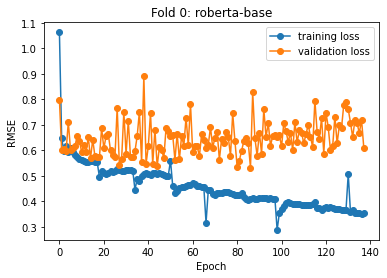

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===== FOLD: 1 =====
FOLD: 1, Epoch: 0, RMSE = 0.8299, checkpoint saved.
FOLD: 1, Epoch: 1, RMSE = 0.611, checkpoint saved.
FOLD: 1, Epoch: 2, Batch 0, RMSE = 0.6109, checkpoint saved.
FOLD: 1, Epoch: 2, Batch 10, RMSE = 0.6442
FOLD: 1, Epoch: 2, Batch 20, RMSE = 0.6379
FOLD: 1, Epoch: 2, Batch 30, RMSE = 0.6955
FOLD: 1, Epoch: 2, Batch 40, RMSE = 0.6157
FOLD: 1, Epoch: 2, Batch 50, RMSE = 0.6165
FOLD: 1, Epoch: 2, Batch 60, RMSE = 0.6308
FOLD: 1, Epoch: 2, Batch 70, RMSE = 0.7158
FOLD: 1, Epoch: 2, Batch 80, RMSE = 0.6295
FOLD: 1, Epoch: 2, Batch 90, RMSE = 0.6178
FOLD: 1, Epoch: 2, Batch 100, RMSE = 0.6769
FOLD: 1, Epoch: 2, Batch 110, RMSE = 0.6603
FOLD: 1, Epoch: 2, Batch 120, RMSE = 0.6209
FOLD: 1, Epoch: 2, Batch 130, RMSE = 0.73
FOLD: 1, Epoch: 2, Batch 140, RMSE = 0.6538
FOLD: 1, Epoch: 2, Batch 141, RMSE = 0.6691
FOLD: 1, Epoch: 3, Batch 0, RMSE = 0.6735
FOLD: 1, Epoch: 3, Batch 10, RMSE = 0.7096
FOLD: 1, Epoch: 3, Batch 20, RMSE = 0.6131
FOLD: 1, Epoch: 3, Batch 30, RMSE = 0.6

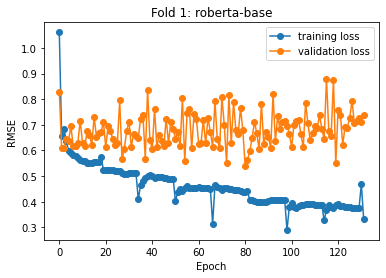

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===== FOLD: 2 =====
FOLD: 2, Epoch: 0, RMSE = 0.8215, checkpoint saved.
FOLD: 2, Epoch: 1, RMSE = 0.6207, checkpoint saved.
FOLD: 2, Epoch: 2, Batch 0, RMSE = 0.6055, checkpoint saved.
FOLD: 2, Epoch: 2, Batch 10, RMSE = 0.5874, checkpoint saved.
FOLD: 2, Epoch: 2, Batch 20, RMSE = 0.5636, checkpoint saved.
FOLD: 2, Epoch: 2, Batch 30, RMSE = 0.6488
FOLD: 2, Epoch: 2, Batch 40, RMSE = 0.5654
FOLD: 2, Epoch: 2, Batch 50, RMSE = 0.5873
FOLD: 2, Epoch: 2, Batch 60, RMSE = 0.562, checkpoint saved.
FOLD: 2, Epoch: 2, Batch 70, RMSE = 0.6119
FOLD: 2, Epoch: 2, Batch 80, RMSE = 0.5587, checkpoint saved.
FOLD: 2, Epoch: 2, Batch 90, RMSE = 0.6094
FOLD: 2, Epoch: 2, Batch 100, RMSE = 0.5744
FOLD: 2, Epoch: 2, Batch 110, RMSE = 0.6499
FOLD: 2, Epoch: 2, Batch 120, RMSE = 0.5398, checkpoint saved.
FOLD: 2, Epoch: 2, Batch 130, RMSE = 0.648
FOLD: 2, Epoch: 2, Batch 140, RMSE = 0.6004
FOLD: 2, Epoch: 2, Batch 141, RMSE = 0.6326
FOLD: 2, Epoch: 3, Batch 0, RMSE = 0.6474
FOLD: 2, Epoch: 3, Batch 10, 

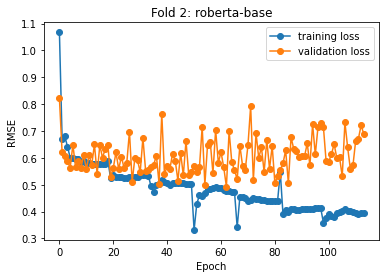

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===== FOLD: 3 =====
FOLD: 3, Epoch: 0, RMSE = 0.8244, checkpoint saved.
FOLD: 3, Epoch: 1, RMSE = 0.609, checkpoint saved.
FOLD: 3, Epoch: 2, Batch 0, RMSE = 0.6098
FOLD: 3, Epoch: 2, Batch 10, RMSE = 0.5921, checkpoint saved.
FOLD: 3, Epoch: 2, Batch 20, RMSE = 0.5823, checkpoint saved.
FOLD: 3, Epoch: 2, Batch 30, RMSE = 0.607
FOLD: 3, Epoch: 2, Batch 40, RMSE = 0.5723, checkpoint saved.
FOLD: 3, Epoch: 2, Batch 50, RMSE = 0.6516
FOLD: 3, Epoch: 2, Batch 60, RMSE = 0.5652, checkpoint saved.
FOLD: 3, Epoch: 2, Batch 70, RMSE = 0.683
FOLD: 3, Epoch: 2, Batch 80, RMSE = 0.5981
FOLD: 3, Epoch: 2, Batch 90, RMSE = 0.5671
FOLD: 3, Epoch: 2, Batch 100, RMSE = 0.6876
FOLD: 3, Epoch: 2, Batch 110, RMSE = 0.5547, checkpoint saved.
FOLD: 3, Epoch: 2, Batch 120, RMSE = 0.6661
FOLD: 3, Epoch: 2, Batch 130, RMSE = 0.5993
FOLD: 3, Epoch: 2, Batch 140, RMSE = 0.5485, checkpoint saved.
FOLD: 3, Epoch: 2, Batch 141, RMSE = 0.5502
FOLD: 3, Epoch: 3, Batch 0, RMSE = 0.555
FOLD: 3, Epoch: 3, Batch 10, RM

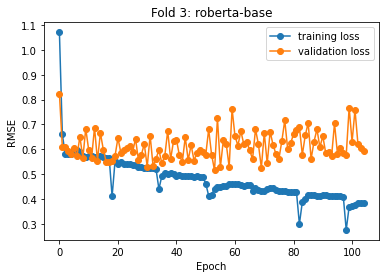

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===== FOLD: 4 =====
FOLD: 4, Epoch: 0, RMSE = 0.7972, checkpoint saved.
FOLD: 4, Epoch: 1, RMSE = 0.5936, checkpoint saved.
FOLD: 4, Epoch: 2, Batch 0, RMSE = 0.5955
FOLD: 4, Epoch: 2, Batch 10, RMSE = 0.5788, checkpoint saved.
FOLD: 4, Epoch: 2, Batch 20, RMSE = 0.5788
FOLD: 4, Epoch: 2, Batch 30, RMSE = 0.6056
FOLD: 4, Epoch: 2, Batch 40, RMSE = 0.5695, checkpoint saved.
FOLD: 4, Epoch: 2, Batch 50, RMSE = 0.685
FOLD: 4, Epoch: 2, Batch 60, RMSE = 0.5565, checkpoint saved.
FOLD: 4, Epoch: 2, Batch 70, RMSE = 0.64
FOLD: 4, Epoch: 2, Batch 80, RMSE = 0.6188
FOLD: 4, Epoch: 2, Batch 90, RMSE = 0.5843
FOLD: 4, Epoch: 2, Batch 100, RMSE = 0.6448
FOLD: 4, Epoch: 2, Batch 110, RMSE = 0.5502, checkpoint saved.
FOLD: 4, Epoch: 2, Batch 120, RMSE = 0.7447
FOLD: 4, Epoch: 2, Batch 130, RMSE = 0.5465, checkpoint saved.
FOLD: 4, Epoch: 2, Batch 140, RMSE = 0.5513
FOLD: 4, Epoch: 2, Batch 141, RMSE = 0.5455, checkpoint saved.
FOLD: 4, Epoch: 3, Batch 0, RMSE = 0.5413, checkpoint saved.
FOLD: 4, Ep

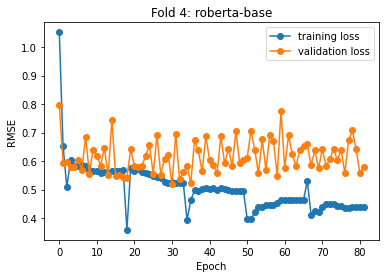

CV: [0.5322, 0.54, 0.4933, 0.516, 0.5182]
Average CV: 0.5199

CPU times: user 1h 24min 25s, sys: 1min 43s, total: 1h 26min 9s
Wall time: 1h 34min 57s


In [30]:
%%time
        
grouped_LLRD = True    # True: apply LLRD on grouped basis; False: apply LLRD on invidual layers.
reinit_n_layers = 5    # Number of last layers to reinitialize on the model.
swa_lr = 2e-6          # Provide a value (e.g. 2e-6) to apply Stochastic Weight Averaging. Else input None.
frequent_eval = True   # If True, perform frequent evaluation within epochs.
                       # Remember to increase the early stopping threshold if using frequent_eval.

if __name__ == "__main__":
    run_training(df, model_head = "pooler", 
                 grouped_LLRD = grouped_LLRD, 
                 reinit_n_layers = reinit_n_layers,
                 swa_lr = swa_lr,
                 frequent_eval = frequent_eval
                )    

# Plot Layer-wise Learning Rate Decay

In [31]:
import plotly
import plotly.graph_objs as go
import plotly.express as px

def get_lr_trace(learning_rates, name="", color="blue"):    
    return go.Scatter(            
            x = list(range(0, len(learning_rates), 1)), 
            y = learning_rates, 
            texttemplate = "%{y:.10f}",
            mode = 'lines',      # Can use 'lines' or 'markers+lines'
            name = name,
            marker = dict(color=color)
        )

def plot_LLRD(df_LR, grouped_LLRD, swa_lr, fold=0):
        
    if grouped_LLRD == True:
        colors = ["lightskyblue", "gold", "green", "red"]                 
        cols = ['regressor', 'layer8', 'layer4', 'layer0']
        cols_name = ['pooler & regressor', 'layer 8,9,10,11', 'layer 4,5,6,7', 'embeddings & layer 0,1,2,3']
        title = "Grouped Layer-wise Learning Rate Decay"
    else:
        colors = ["aqua", "lightskyblue", "teal", "blue", "navy", "gold", "orange", "olive", 
                  "lime", "green", "hotpink", "fuchsia", "blueviolet", "purple", "red"]
        cols = [col for col in df_LR.columns if col != 'fold']
        cols_name = cols
        cols.reverse()    # To show last layer at the top.
        title = "Layer-wise Learning Rate Decay"

    if swa_lr is not None: title = title + " (with SWA)"
        
    traces = []    
    for i, col in enumerate(cols):
        traces.append(get_lr_trace(df_LR[col], name=cols_name[i], color=colors[i]))

    fig = go.Figure(
        data = traces,
        layout = go.Layout(
            template = 'plotly_white',
            title = {'text': title, 'font_family': 'Arial', 'font_size': 20, 'font_color': 'darkred'},
            legend = {'itemclick': 'toggleothers'},
            hovermode = 'x unified',  # can use 'x' or 'x unified'        
            xaxis = {'exponentformat': 'none', 'showexponent': 'none', 
                     'tickfont': {'family': 'Arial', 'size': 14},
                     'title': {'text': 'Steps', 'font_family': 'Arial', 'font_size': 16}
                    },
            yaxis = {'exponentformat': 'e', 'showexponent': 'all',
                     'tickfont': {'family': 'Arial', 'size': 14},
                     'title': {'text': 'Learning rate', 'font_family': 'Arial', 'font_size': 16}
                    }
        )
    )

    fig.show()
    plotly.offline.plot(fig, filename=f'LR_fold{fold}.html', auto_open=True)

In [32]:
pd.options.display.float_format = '{:,.10f}'.format
#pd.reset_option('display.float_format')

df_LR = pd.read_csv("LR_fold0.csv")
df_LR

,embeddings,layer0,layer1,layer2,layer3,layer4,layer5,layer6,layer7,layer8,layer9,layer10,layer11,pooler,regressor,fold
0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0
1,0.0000000200,0.0000000200,0.0000000200,0.0000000200,0.0000000200,0.0000000350,0.0000000350,0.0000000350,0.0000000350,0.0000000700,0.0000000700,0.0000000700,0.0000000700,0.0000000720,0.0000000720,0
2,0.0000000400,0.0000000400,0.0000000400,0.0000000400,0.0000000400,0.0000000700,0.0000000700,0.0000000700,0.0000000700,0.0000001400,0.0000001400,0.0000001400,0.0000001400,0.0000001440,0.0000001440,0
3,0.0000000600,0.0000000600,0.0000000600,0.0000000600,0.0000000600,0.0000001050,0.0000001050,0.0000001050,0.0000001050,0.0000002100,0.0000002100,0.0000002100,0.0000002100,0.0000002160,0.0000002160,0
4,0.0000000800,0.0000000800,0.0000000800,0.0000000800,0.0000000800,0.0000001400,0.0000001400,0.0000001400,0.0000001400,0.0000002800,0.0000002800,0.0000002800,0.0000002800,0.0000002880,0.0000002880,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0
1416,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0
1417,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0
1418,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0.0000020000,0


In [33]:
plot_LLRD(df_LR, grouped_LLRD, swa_lr, fold=0)

In [34]:
df_LR = pd.read_csv("LR_fold4.csv")
plot_LLRD(df_LR, grouped_LLRD, swa_lr, fold=4)

#### If you're not able to see the plot, click the links below for:
- sample of Layer-wise Learning Rate Decay
- sample of Layer-wise Learning Rate Decay (with SWA)
- sample of Grouped Layer-wise Learning Rate Decay
- sample of Grouped Layer-wise Learning Rate Decay (with SWA)


In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')    

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    7.6 GB
